In [1]:
%matplotlib notebook

import pandas
import numpy
from numpy import random
from matplotlib import pyplot
import pickle

In [2]:
ROOT = '/scr-ssd/mimic/'

In [3]:
def load_targets(patients, part, min_length=1000, reject_nan=False):
    targets = {}
    for patient in patients:
        path = ROOT + part + '/' + str(patient) + '.y.pkl'
        with open(path, 'rb') as f:
            t = pickle.load(f)
            t = {
                tuple([int(i) for i in k.split('_')]): {
                    'sys': t[k][:,0][numpy.isfinite(t[k][:,0])],
                    'dia': t[k][:,1][numpy.isfinite(t[k][:,1])]
                }
                for k in t
                if t[k] is not None
            }
            t = {
                k: {
                    i: t[k][i].mean()
                    for i in ['sys', 'dia']
                }
                for k in t if all(t[k][i].size >= min_length for i in ['sys', 'dia'])
            }
            targets.update(t)
    return pandas.DataFrame(targets).T

In [4]:
def summarize_data(data, key, bins, labels):
    bin_data = lambda k: data[data[key].between(bins[k]+1e-9, bins[k+1])]
    summary = pandas.DataFrame({
        (i, j): {
            labels[k]: getattr(bin_data(k)[i], j)()
            for k in range(len(labels))
        }
        for i in ['sys', 'dia'] for j in ['mean', 'std']
    })
    return summary

In [5]:
def plot_cut(x, histbins, cutbins, centroids):
    pyplot.figure(figsize=[7, 3])
    x.hist(bins=histbins, grid=False)
    for i in cutbins[1:-1]:
        pyplot.axvline(x=i+1, color='k', linestyle='--')
    pyplot.plot(centroids, numpy.zeros(len(centroids)), 'ok')

In [6]:
def plot_summary(summary, x):
    pyplot.figure(figsize=(6, 5))
    u1 = summary[('sys', 'mean')]
    s1 = summary[('sys', 'std')]
    u2 = summary[('dia', 'mean')]
    s2 = summary[('dia', 'std')]

    pyplot.plot(x, u1, '--b')
    pyplot.plot(x, u2, '--r')
    pyplot.plot(x, u1, '.k')
    pyplot.plot(x, u2, '.k')
    pyplot.fill_between(x, u1 + s1, u1 - s1, alpha=0.1, color='b')
    pyplot.fill_between(x, u2 + s2, u2 - s2, alpha=0.1, color='r')
    pyplot.legend(['Systolic', 'Diastolic'])

In [7]:
metadata = pandas.read_csv(ROOT + 'metadata.csv').set_index(['record_id', 'segment'])
patients_train = [int(i.strip()) for i in open('/scr-ssd/mimic/train.txt').readlines()]

## By Gender

In [9]:
is_good = metadata['gender'].notna()
patients_labeled = metadata[is_good].reset_index()['record_id']
patients = set(patients_labeled).intersection(patients_train)
targets = load_targets(patients, part='train')
data = metadata.reindex(targets.index)
data[['sys', 'dia']] = targets[['sys', 'dia']]
data[:5]

subject_id                     time  sig_len  \
3407874 15       69027  2165-07-20 17:06:34.000  1942125   
        39       69027  2165-07-20 00:12:59.000  3826125   
        41       69027  2165-07-20 08:49:03.000   584000   
        26       69027  2165-07-20 22:42:41.000   231875   
        27       69027  2165-07-20 23:13:36.000   405375   

                               sig_name  hadm_id gender         dob  age  \
3407874 15  ('ABP', 'II', 'PLETH', 'V')   152934      F  2101-03-31   64   
        39  ('ABP', 'II', 'PLETH', 'V')   152934      F  2101-03-31   64   
        41  ('ABP', 'II', 'PLETH', 'V')   152934      F  2101-03-31   64   
        26  ('ABP', 'II', 'PLETH', 'V')   152934      F  2101-03-31   64   
        27   ('ABP', 'I', 'PLETH', 'V')   152934      F  2101-03-31   64   

            weight  height       sys       dia  
3407874 15   108.7    61.0  123.1875  67.56250  
        39   108.7    61.0  104.6250  66.56250  
        41   108.7    61.0  104.6250  63.71875  
        26   108.7    61.0   85.6875  59.34375  
        27   108.7    61.0   92.5625  50.90625

<IPython.core.display.Javascript object>


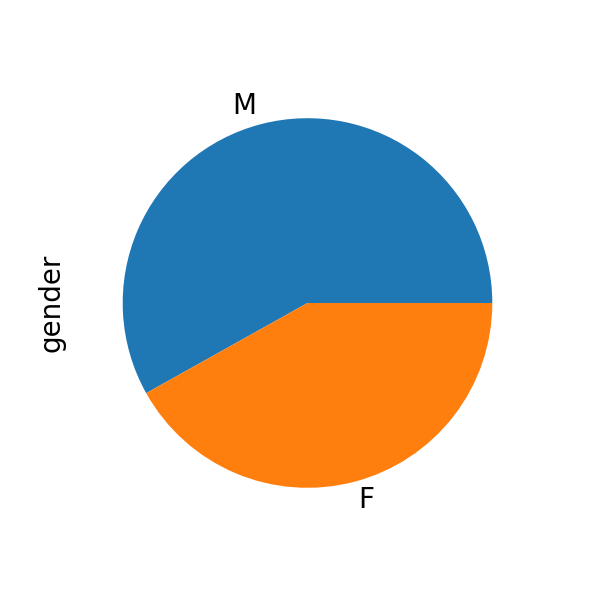

In [19]:
pyplot.figure(figsize=[3,3])
data['gender'].value_counts().plot.pie()

In [20]:
summary = pandas.DataFrame({
    (i, j): {
        k: getattr(data[data['gender'] == k][i], j)()
        for k in ['M', 'F']
    }
    for i in ['sys', 'dia'] for j in ['mean', 'std']
})
summary.T.round(decimals=1)

M      F
sys mean  122.0  122.1
    std    23.5   23.9
dia mean   60.7   60.2
    std    14.1   15.6

<IPython.core.display.Javascript object>


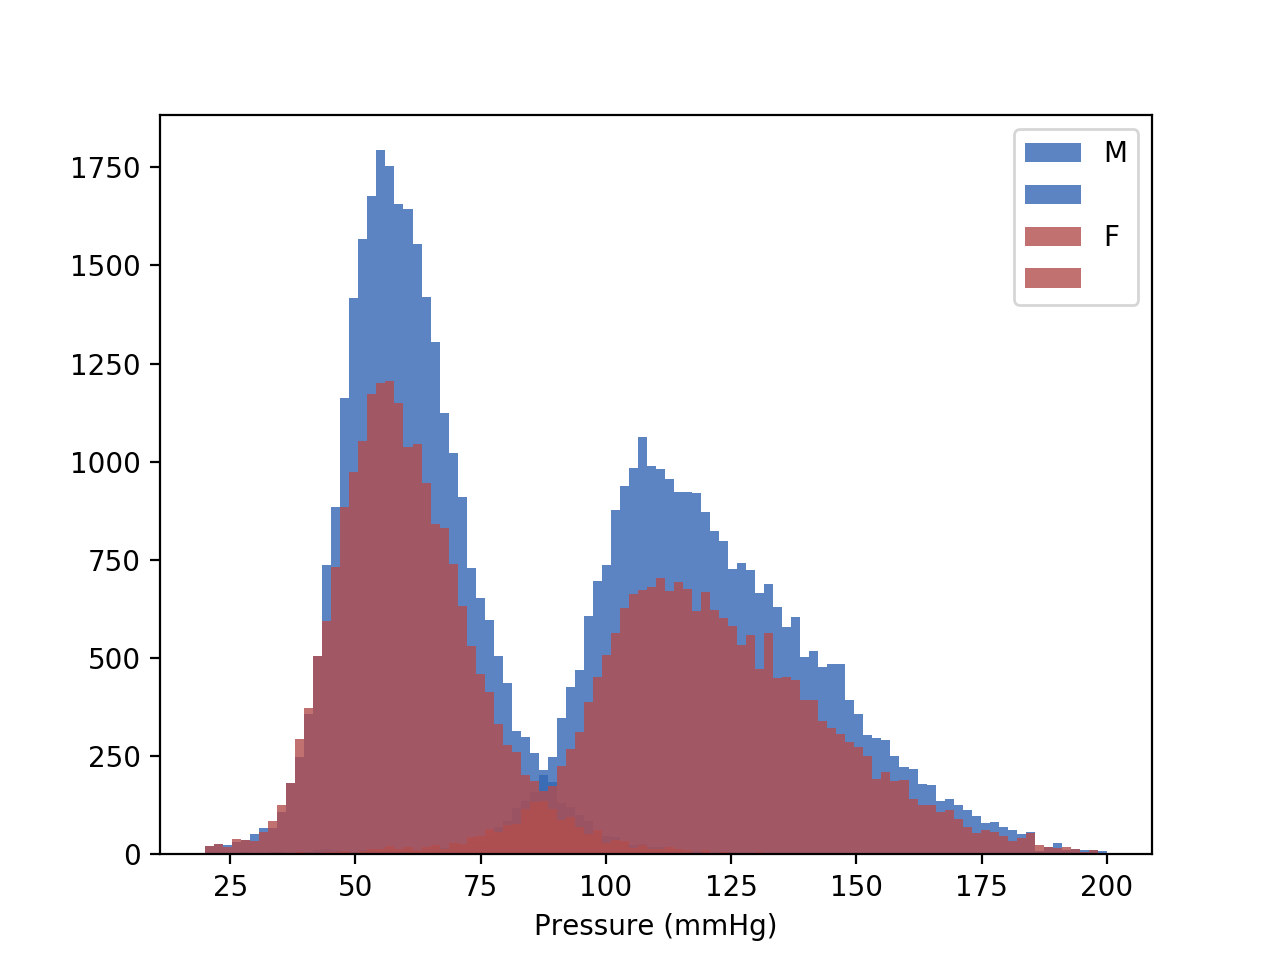

In [21]:
fig = pyplot.figure()
args = {'bins': 100, 'range': (20, 200)}
pyplot.hist(data[data['gender'] == 'M']['sys'], color=(0.2, 0.4, 0.7, 0.8), **args)
pyplot.hist(data[data['gender'] == 'M']['dia'], color=(0.2, 0.4, 0.7, 0.8), **args)
pyplot.hist(data[data['gender'] == 'F']['sys'], color=(0.7, 0.3, 0.3, 0.8), **args)
pyplot.hist(data[data['gender'] == 'F']['dia'], color=(0.7, 0.3, 0.3, 0.8), **args)
pyplot.xlabel('Pressure (mmHg)')
pyplot.legend(['M', None, 'F', None])

## By Hypertensive Diagnosis

In [17]:
is_good = metadata['icd_codes'].notna()
patients_labeled = metadata[is_good].reset_index()['record_id']
patients = set(patients_labeled).intersection(patients_train)
targets = load_targets(patients, part='train')
data = metadata.reindex(targets.index)
data[['sys', 'dia']] = targets[['sys', 'dia']]
read_list = lambda i: eval(i) if type(i) is str else []
list_cols = ['icd_codes']
data[list_cols] = data[list_cols].applymap(read_list)
data['hypertensive'] = data['icd_codes'].apply(lambda i: '4019' in i)
data[:5]

hadm_id  subject_id                     time  sig_len  \
3407874 15   152934       69027  2165-07-20 17:06:34.000  1942125   
        39   152934       69027  2165-07-20 00:12:59.000  3826125   
        41   152934       69027  2165-07-20 08:49:03.000   584000   
        26   152934       69027  2165-07-20 22:42:41.000   231875   
        27   152934       69027  2165-07-20 23:13:36.000   405375   

                               sig_name gender         dob  age  weight  \
3407874 15  ('ABP', 'II', 'PLETH', 'V')      F  2101-03-31   64   108.7   
        39  ('ABP', 'II', 'PLETH', 'V')      F  2101-03-31   64   108.7   
        41  ('ABP', 'II', 'PLETH', 'V')      F  2101-03-31   64   108.7   
        26  ('ABP', 'II', 'PLETH', 'V')      F  2101-03-31   64   108.7   
        27   ('ABP', 'I', 'PLETH', 'V')      F  2101-03-31   64   108.7   

            height                                          icd_codes  \
3407874 15    61.0  [99667, 0389, 99592, 78552, 99851, 2851, 99831...   
        39    61.0  [99667, 0389, 99592, 78552, 99851, 2851, 99831...   
        41    61.0  [99667, 0389, 99592, 78552, 99851, 2851, 99831...   
        26    61.0  [99667, 0389, 99592, 78552, 99851, 2851, 99831...   
        27    61.0  [99667, 0389, 99592, 78552, 99851, 2851, 99831...   

                 sys       dia  hypertensive  
3407874 15  123.1875  67.56250          True  
        39  104.6250  66.56250          True  
        41  104.6250  63.71875          True  
        26   85.6875  59.34375          True  
        27   92.5625  50.90625          True

<IPython.core.display.Javascript object>


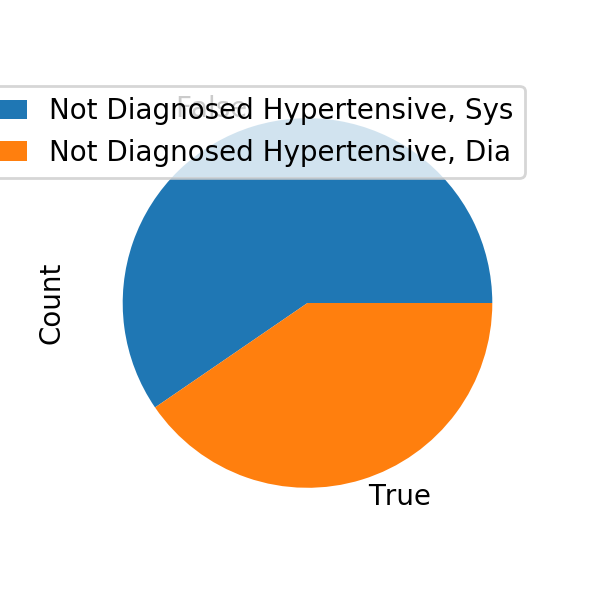

In [18]:
pyplot.figure(figsize=[3,3])
data['hypertensive'].value_counts().plot.pie()

In [19]:
summary = pandas.DataFrame({
    (i, j): {
        k: getattr(data[data['hypertensive'] == k][i], j)()
        for k in [True, False]
    }
    for i in ['sys', 'dia'] for j in ['mean', 'std']
})
summary.T.round(decimals=1)

True   False
sys mean  125.9  119.8
    std    23.7   23.4
dia mean   61.5   60.0
    std    14.8   14.8

<IPython.core.display.Javascript object>


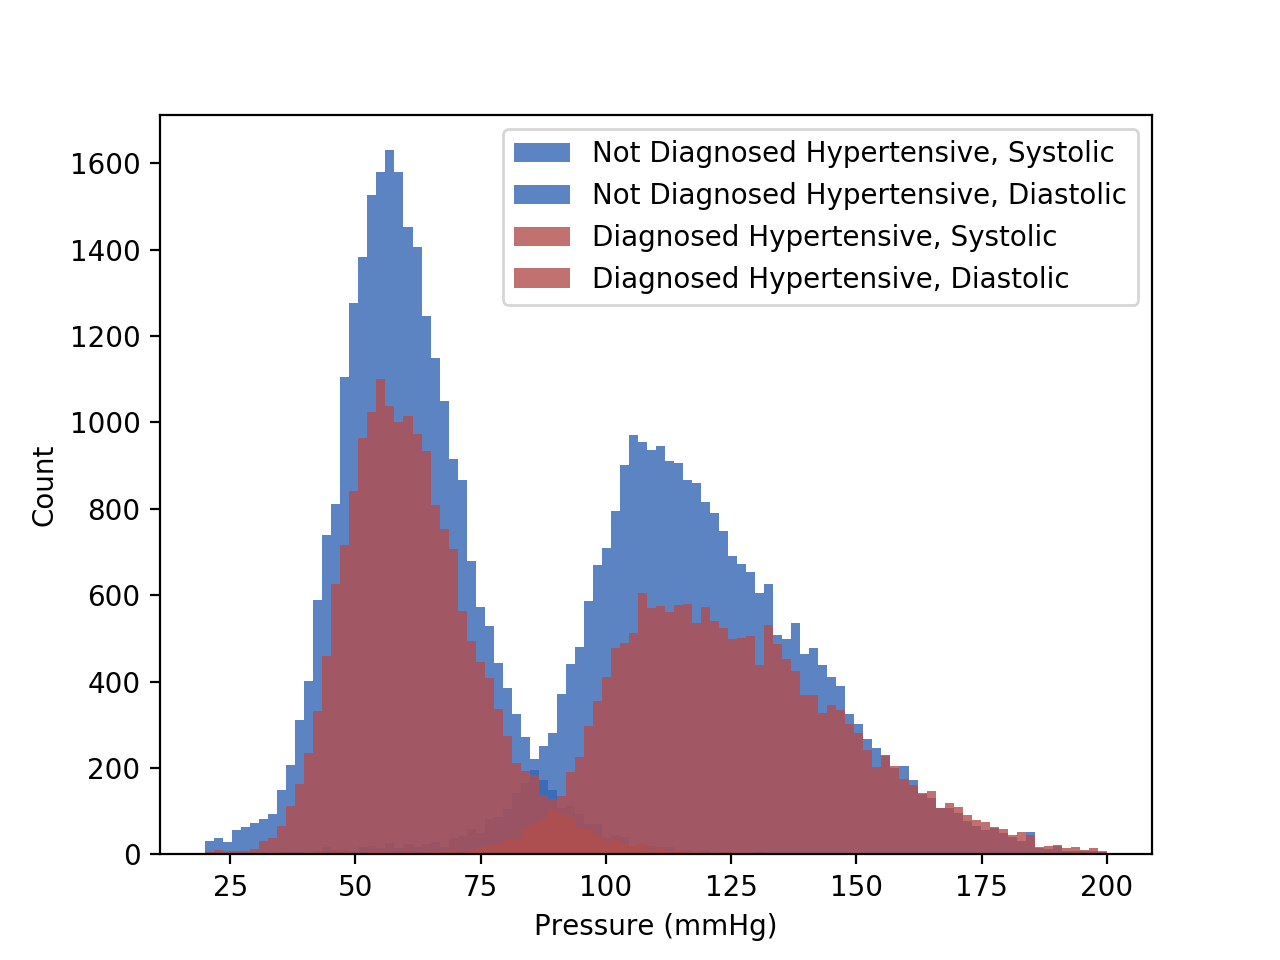

In [23]:
fig = pyplot.figure()
args = {'bins': 100, 'range': (20, 200)}
pyplot.hist(data[~data['hypertensive']]['sys'], color=(0.2, 0.4, 0.7, 0.8), **args)
pyplot.hist(data[~data['hypertensive']]['dia'], color=(0.2, 0.4, 0.7, 0.8), **args)
pyplot.hist(data[data['hypertensive']]['sys'], color=(0.7, 0.3, 0.3, 0.8), **args)
pyplot.hist(data[data['hypertensive']]['dia'], color=(0.7, 0.3, 0.3, 0.8), **args)
pyplot.xlabel('Pressure (mmHg)')
pyplot.ylabel('Count')
pyplot.legend([
    'Not Diagnosed Hypertensive, Systolic', 
    'Not Diagnosed Hypertensive, Diastolic', 
    'Diagnosed Hypertensive, Systolic', 
    'Diagnosed Hypertensive, Diastolic',
])

## By Age

In [8]:
is_labeled = metadata['age'].notna() & metadata['age'].le(89.5)
patients_labeled = metadata[is_labeled].reset_index()['record_id']
patients = set(patients_labeled).intersection(patients_train)
targets = load_targets(patients, part='train')
data = metadata.reindex(targets.index)
data[['sys', 'dia']] = targets[['sys', 'dia']]
data[:5]

hadm_id  subject_id                     time  sig_len  \
3407874 15   152934       69027  2165-07-20 17:06:34.000  1942125   
        39   152934       69027  2165-07-20 00:12:59.000  3826125   
        41   152934       69027  2165-07-20 08:49:03.000   584000   
        26   152934       69027  2165-07-20 22:42:41.000   231875   
        27   152934       69027  2165-07-20 23:13:36.000   405375   

                               sig_name gender         dob  age  weight  \
3407874 15  ('ABP', 'II', 'PLETH', 'V')      F  2101-03-31   64   108.7   
        39  ('ABP', 'II', 'PLETH', 'V')      F  2101-03-31   64   108.7   
        41  ('ABP', 'II', 'PLETH', 'V')      F  2101-03-31   64   108.7   
        26  ('ABP', 'II', 'PLETH', 'V')      F  2101-03-31   64   108.7   
        27   ('ABP', 'I', 'PLETH', 'V')      F  2101-03-31   64   108.7   

            height                                          icd_codes  \
3407874 15    61.0  ['99667', '0389', '99592', '78552', '99851', '...   
        39    61.0  ['99667', '0389', '99592', '78552', '99851', '...   
        41    61.0  ['99667', '0389', '99592', '78552', '99851', '...   
        26    61.0  ['99667', '0389', '99592', '78552', '99851', '...   
        27    61.0  ['99667', '0389', '99592', '78552', '99851', '...   

                 sys       dia  
3407874 15  123.1875  67.56250  
        39  104.6250  66.56250  
        41  104.6250  63.71875  
        26   85.6875  59.34375  
        27   92.5625  50.90625

<IPython.core.display.Javascript object>


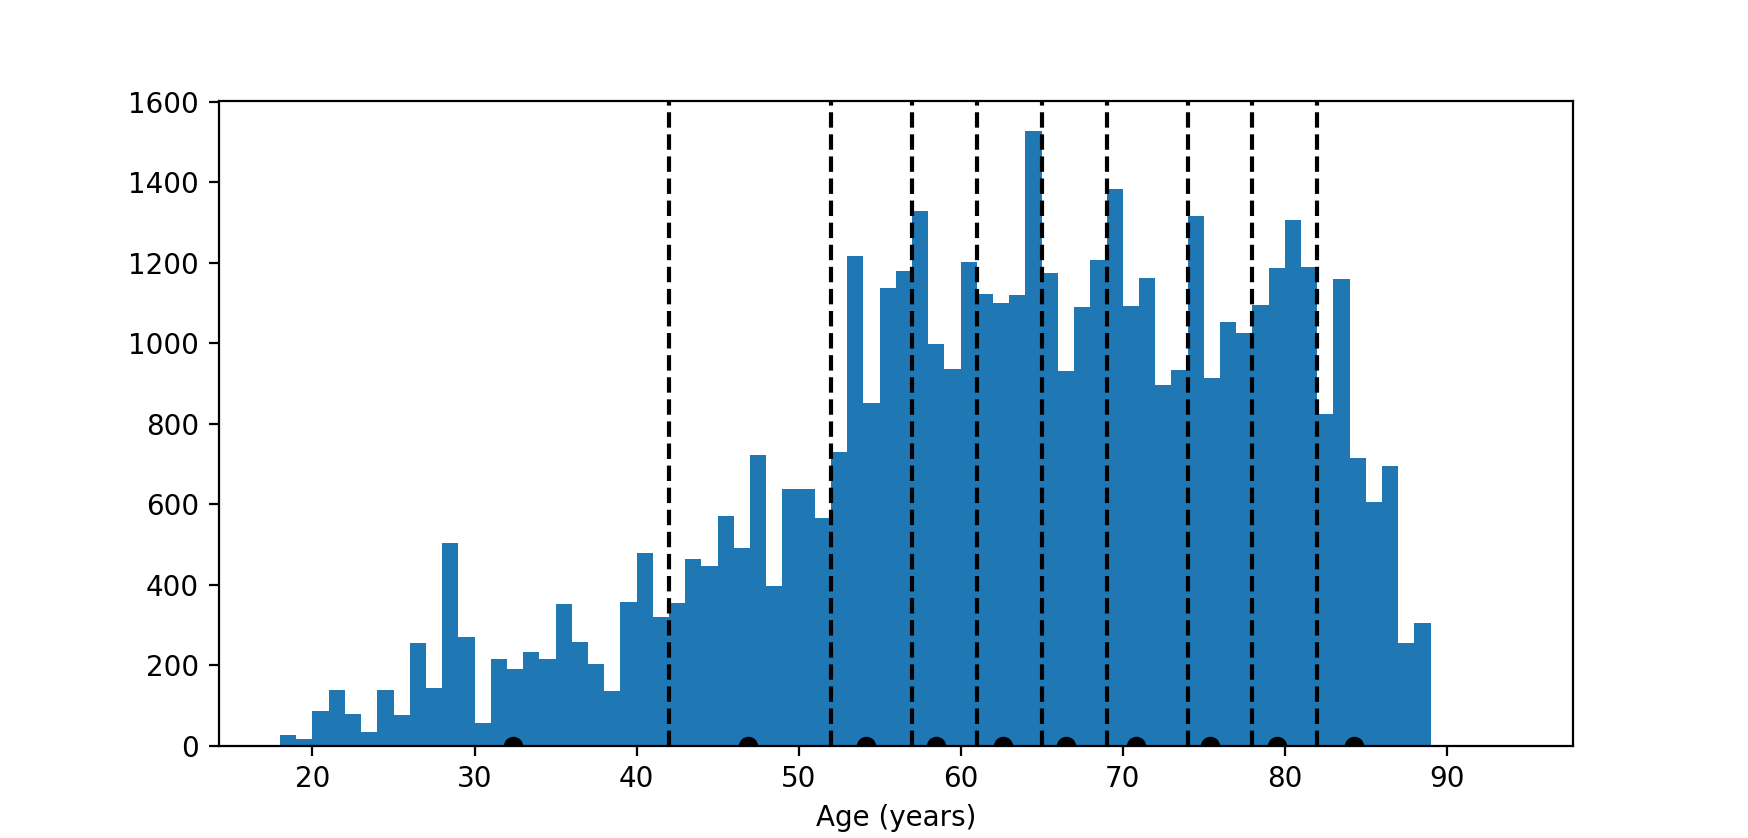

In [9]:
cut, cutbins = pandas.qcut(data['age'], q=10, retbins=True)
centroids = [data[cut == i]['age'].mean() for i in cut.cat.categories]
histbins = range(18, 95)
plot_cut(data['age'], histbins, cutbins, centroids)
pyplot.xlabel('Age (years)')

In [12]:
labels = [int(round(i)) for i in centroids]
summary = summarize_data(data, 'age', cutbins, labels)
summary.T.round(decimals=1)

32     47     54     58     63     67     71     75     80     84
sys mean  120.3  122.2  123.1  119.8  119.7  122.0  122.4  122.6  124.1  125.2
    std    24.0   22.7   23.6   25.4   23.8   23.5   22.1   24.1   22.9   24.6
dia mean   66.6   66.4   64.7   60.2   61.1   58.3   58.6   56.2   56.1   55.9
    std    15.3   14.7   14.2   15.0   14.2   13.4   13.6   13.6   13.4   14.3

<IPython.core.display.Javascript object>


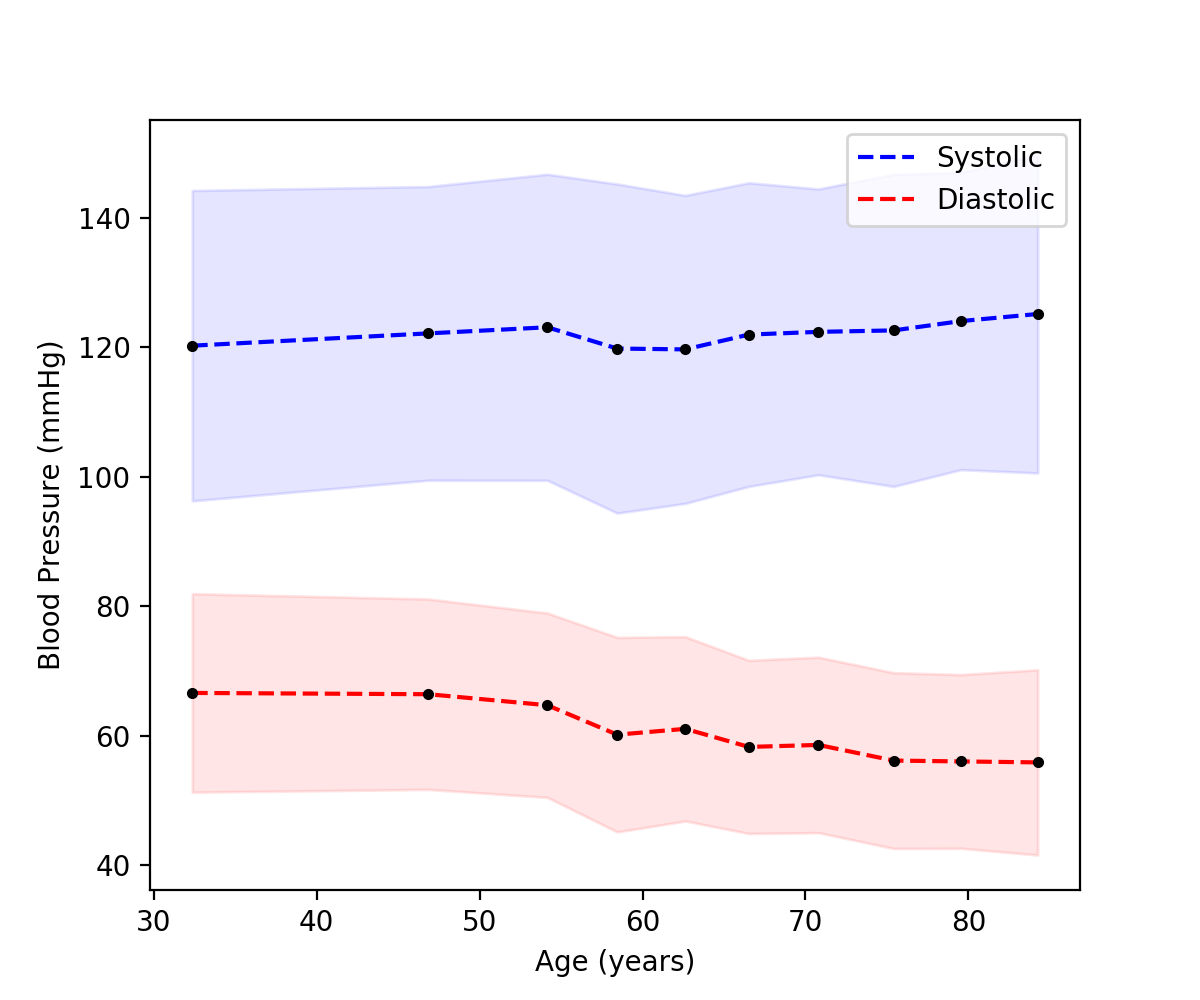

Text(0, 0.5, 'Blood Pressure (mmHg)')

In [16]:
plot_summary(summary, centroids)
pyplot.xlabel('Age (years)')
pyplot.ylabel('Blood Pressure (mmHg)')

## By Weight

In [43]:
key = 'weight'
is_labeled = metadata[key].notna()
is_labeled &= metadata['gender'] == 'M'
patients_labeled = metadata[is_labeled].reset_index()['record_id']
patients = set(patients_labeled).intersection(patients_train)
targets = load_targets(patients, part='train')
data = metadata.reindex(targets.index)
data[['sys', 'dia']] = targets[['sys', 'dia']]
data['weight'] *= 2.2

<IPython.core.display.Javascript object>


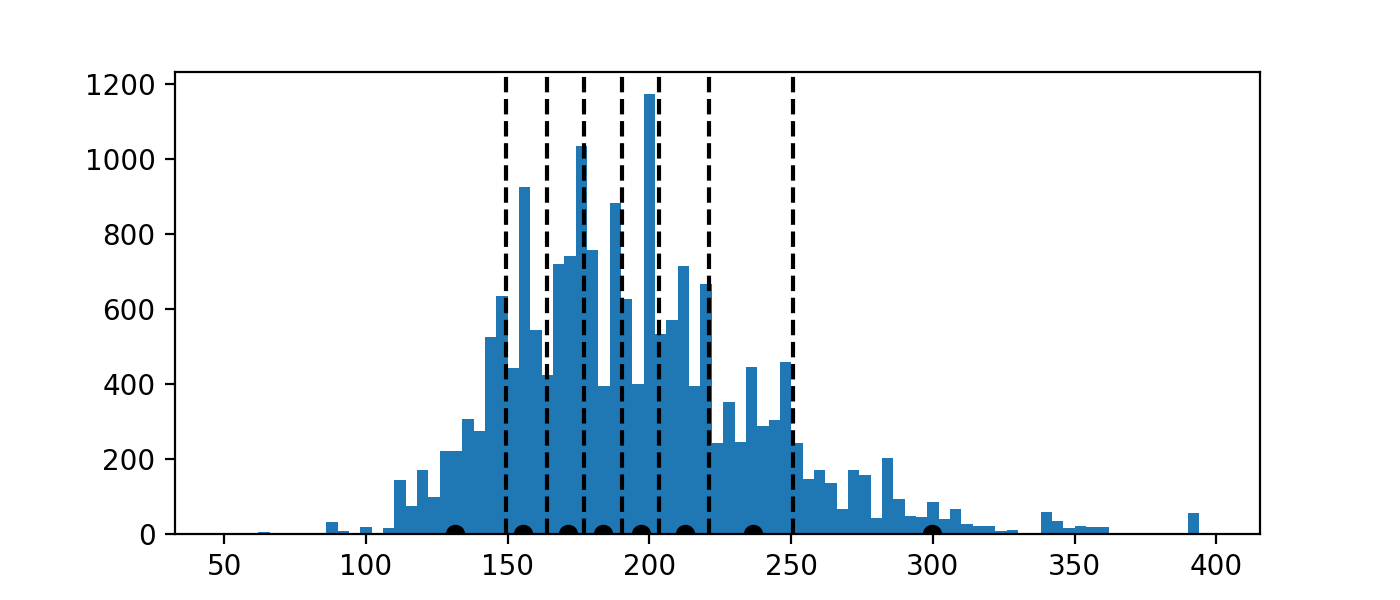

In [44]:
cut, cutbins = pandas.qcut(data[key], q=8, retbins=True)
centroids = [data[cut == i][key].mean() for i in cut.cat.categories]
histbins = range(50, 400, 4)
plot_cut(data[key], histbins, cutbins, centroids)

In [45]:
labels = [int(round(i)) for i in centroids]
summary = summarize_data(data, key, cutbins, labels)
summary.T.round(decimals=1)

132    155    171    184    197    213    236    300
sys mean  123.9  121.8  123.1  126.7  126.0  122.0  121.0  121.1
    std    25.4   25.6   23.1   23.0   20.0   22.1   25.4   21.2
dia mean   58.4   63.0   61.5   62.0   61.1   59.2   61.9   64.1
    std    13.2   13.9   14.5   14.8   11.4   14.5   13.1   13.6

<IPython.core.display.Javascript object>


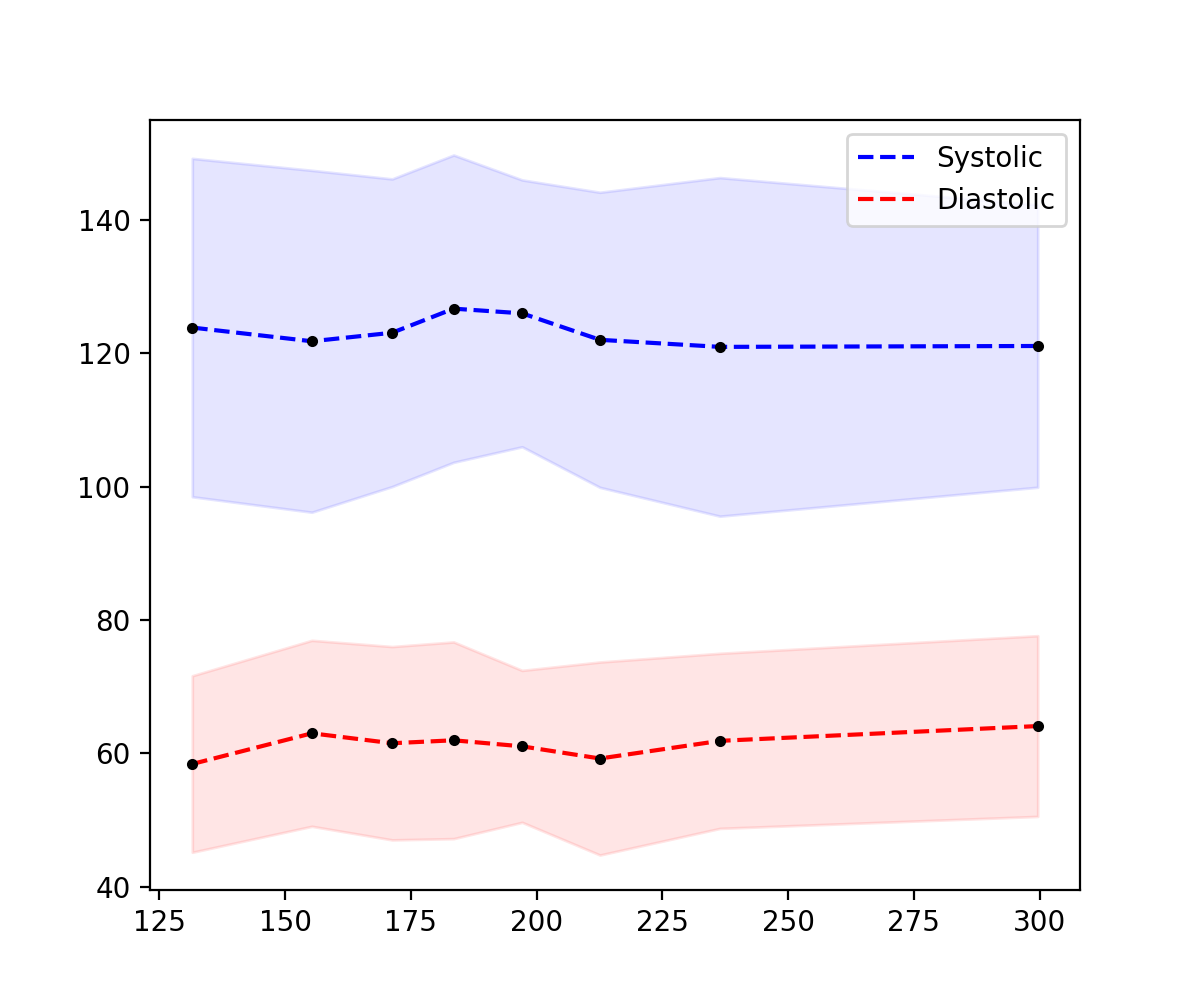

In [46]:
plot_summary(summary, centroids)

## By Height

In [42]:
key = 'height'
is_labeled = metadata[key].notna()
is_labeled &= metadata['gender'] == 'M'
patients_labeled = metadata[is_labeled].reset_index()['record_id']
patients = set(patients_labeled).intersection(patients_train)
targets = load_targets(patients, part='train')
data = metadata.reindex(targets.index)
data[['sys', 'dia']] = targets[['sys', 'dia']]

<IPython.core.display.Javascript object>


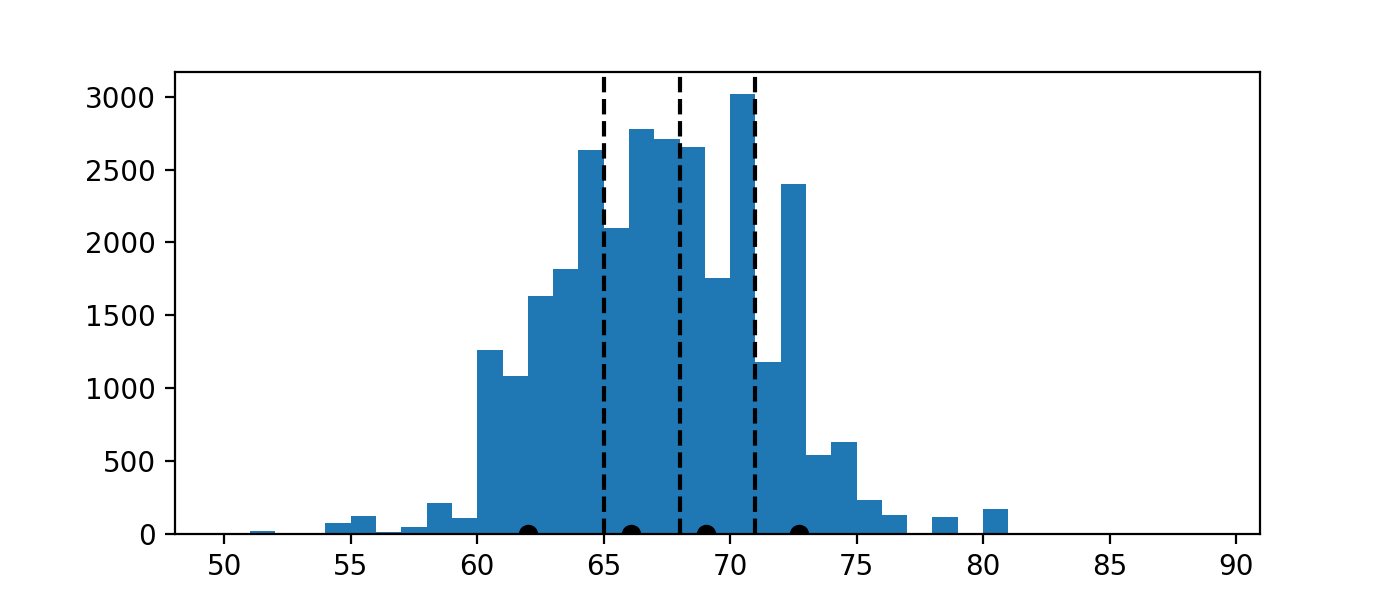

In [39]:
cut, cutbins = pandas.qcut(data[key], q=4, retbins=True)
centroids = [data[cut == i][key].mean() for i in cut.cat.categories]
histbins = range(50, 90)
plot_cut(data[key], histbins, cutbins, centroids)

In [40]:
labels = [int(round(i)) for i in centroids]
summary = summarize_data(data, key, cutbins, labels)
summary.T.round(decimals=1)

62     66     69     73
sys mean  120.0  119.6  121.8  121.1
    std    22.8   22.8   22.8   24.3
dia mean   58.5   59.6   60.9   61.5
    std    15.2   13.8   14.2   14.9

<IPython.core.display.Javascript object>


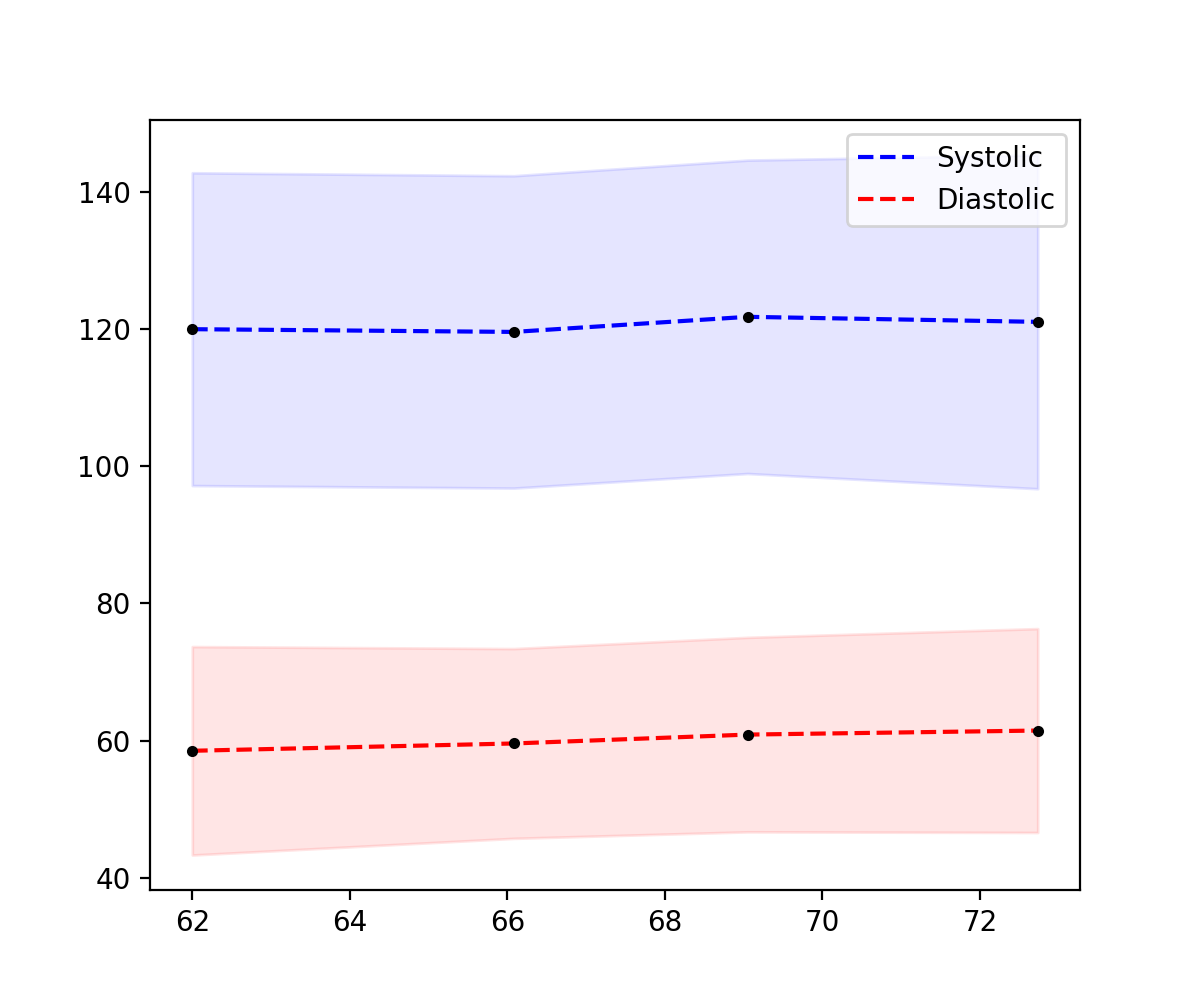

In [41]:
plot_summary(summary, centroids)

## By BMI

In [7]:
metadata['bmi'] = metadata['weight'] / (metadata['height'] * 0.0254) ** 2

In [8]:
is_labeled = metadata['height'].notna() & metadata['weight'].notna() 
is_labeled &= metadata['age'].le(89.5)
is_labeled &= metadata['bmi'] < 60
patients_labeled = metadata[is_labeled].reset_index()['record_id']
patients = set(patients_labeled).intersection(patients_train)
targets = load_targets(patients, part='train')
data = metadata.reindex(targets.index)
data[['sys', 'dia']] = targets[['sys', 'dia']]
data[:5]

subject_id                     time  sig_len  \
3096576 2        77325  2149-11-19 13:44:14.000  8588750   
3407874 15       69027  2165-07-20 17:06:34.000  1942125   
        39       69027  2165-07-20 00:12:59.000  3826125   
        41       69027  2165-07-20 08:49:03.000   584000   
        26       69027  2165-07-20 22:42:41.000   231875   

                               sig_name  hadm_id gender         dob  age  \
3096576 2    ('ABP', 'II', 'RESP', 'V')   195343      F  2072-04-22   77   
3407874 15  ('ABP', 'II', 'PLETH', 'V')   152934      F  2101-03-31   64   
        39  ('ABP', 'II', 'PLETH', 'V')   152934      F  2101-03-31   64   
        41  ('ABP', 'II', 'PLETH', 'V')   152934      F  2101-03-31   64   
        26  ('ABP', 'II', 'PLETH', 'V')   152934      F  2101-03-31   64   

            weight  height        bmi       sys       dia  
3096576 2     58.6    66.0  20.851741  121.4375  67.56250  
3407874 15   108.7    61.0  45.279585  123.1875  67.56250  
        39   108.7    61.0  45.279585  104.6250  66.56250  
        41   108.7    61.0  45.279585  104.6250  63.71875  
        26   108.7    61.0  45.279585   85.6875  59.34375

<IPython.core.display.Javascript object>


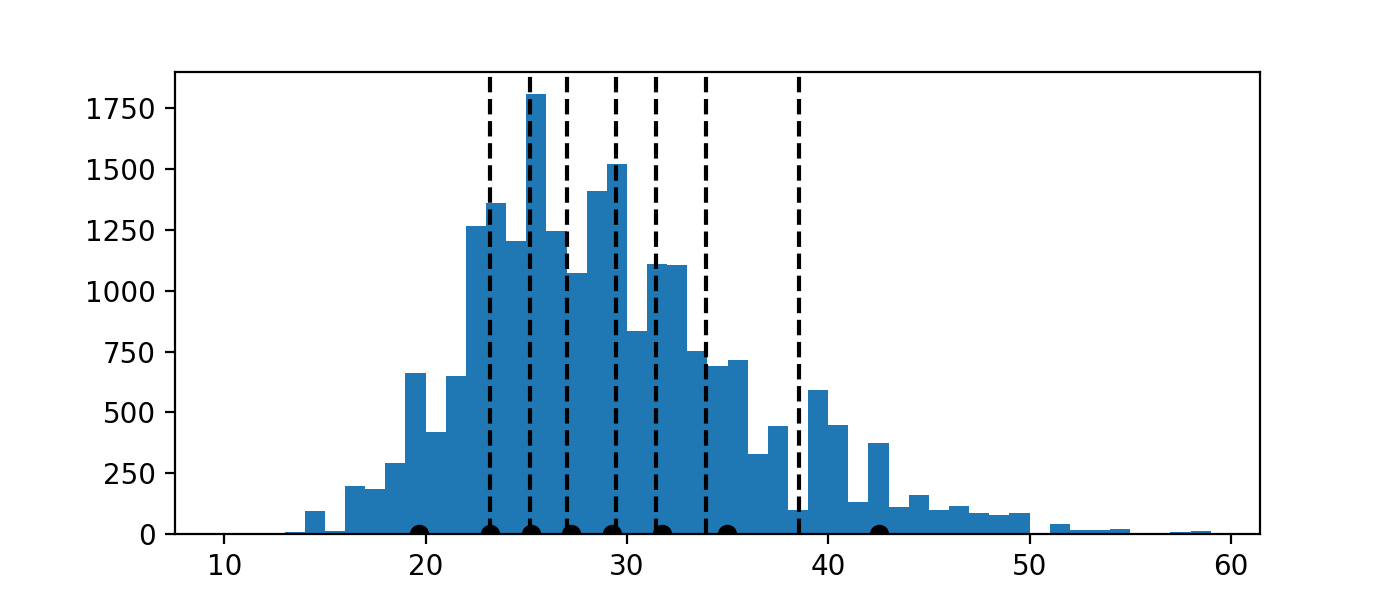

In [10]:
key = 'bmi'
cut, cutbins = pandas.qcut(data[key], q=8, retbins=True)
centroids = [data[cut == i][key].mean() for i in cut.cat.categories]
histbins = range(10, 60)
plot_cut(data[key], histbins, cutbins, centroids)

In [11]:
labels = [int(round(i)) for i in centroids]
summary = summarize_data(data, key, cutbins, labels)
summary.T.round(decimals=1)

20     23     25     27     29     32     35     43
sys mean  121.8  118.6  123.6  122.9  122.0  121.2  121.9  117.9
    std    22.4   28.1   24.2   21.5   19.5   24.0   22.4   21.5
dia mean   60.2   59.1   61.0   60.9   60.7   58.9   61.0   61.8
    std    14.3   16.0   14.3   14.0   13.3   14.5   13.1   13.3

<IPython.core.display.Javascript object>


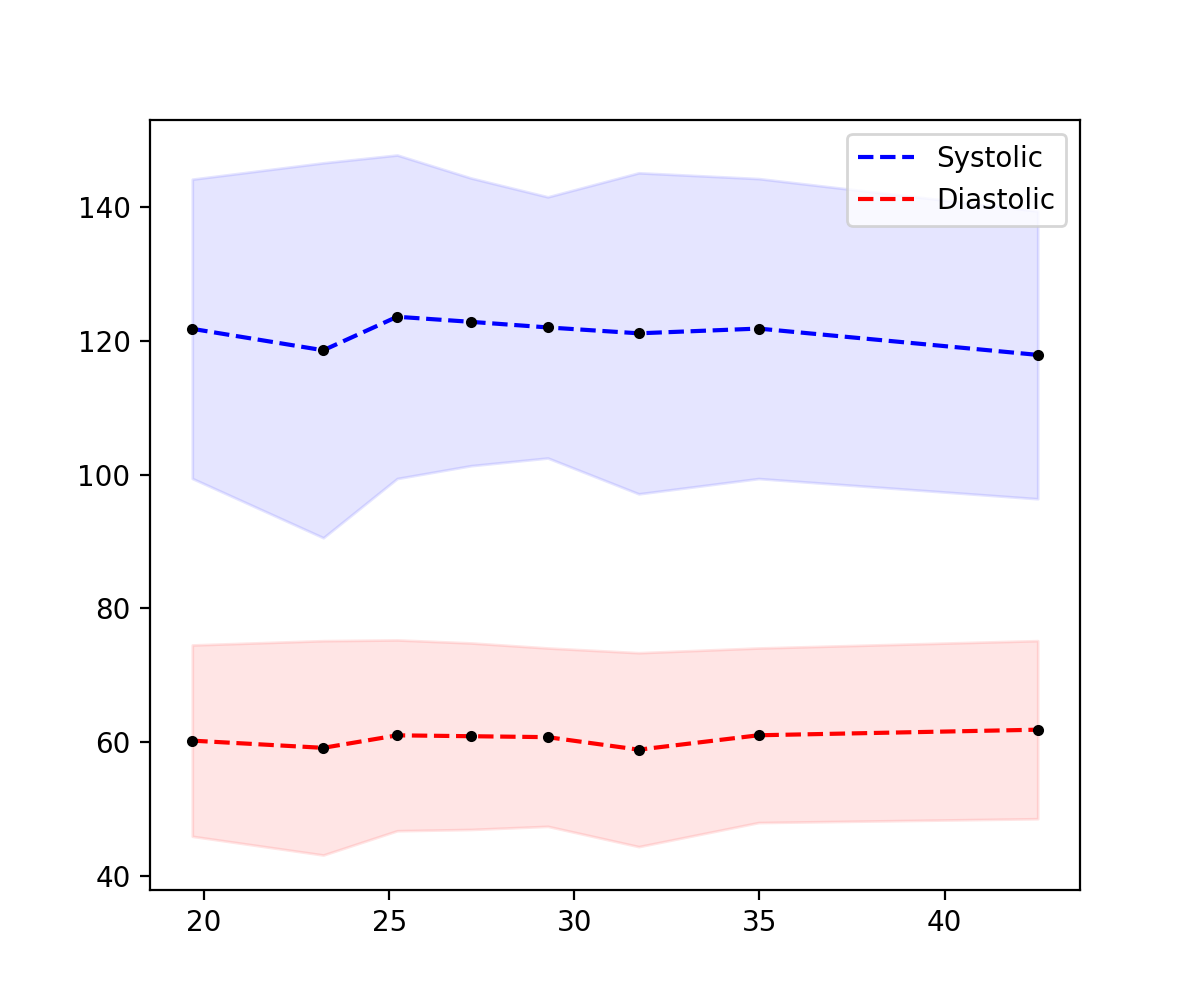

In [12]:
plot_summary(summary, centroids)